In [ ]:
# Operating System module for interacting with the operating system
import os

# TensorFlow and Keras for deep learning framework and tools
import tensorflow as tf
import keras

# OpenCV for image processing and computer vision tasks
import cv2

# Pandas for data manipulation and analysis
import pandas as pd

# NumPy for numerical computing with arrays and matrices
import numpy as np

# Matplotlib for data visualization
import matplotlib.pyplot as plt
plt.style.use('default')  # Set default style for Matplotlib

# Scikit-learn for machine learning utilities
from sklearn.model_selection import train_test_split

# TensorFlow's Keras-specific modules for image preprocessing and callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *  # Importing all layers, might not be the best practice

# TensorFlow's pre-built ResNet50V2 model for transfer learning
from tensorflow.keras.applications import ResNet50V2

# **Visualizing Classes**

In [ ]:
row, col = 48, 48  # Image dimensions
classes = 7  # Number of classes

train_dir = '/kaggle/input/fer2013/train/'  # Training data directory
test_dir = '/kaggle/input/fer2013/test/'  # Test data directory

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])  # Create DataFrame for counts
    return df

train_count = count_exp(train_dir, 'Train')  # Count train data
test_count = count_exp(test_dir, 'Test')  # Count test data

combined_counts = pd.concat([train_count, test_count])  # Combine counts
transposed_counts = combined_counts.transpose()  # Transpose DataFrame
styled_table = transposed_counts.style.background_gradient(cmap='Pastel1')  # Style table
styled_table  # Display styled table

,Train,Test
surprise,3171,831
fear,4097,1024
angry,3995,958
neutral,4965,1233
sad,4830,1247
disgust,436,111
happy,7215,1774


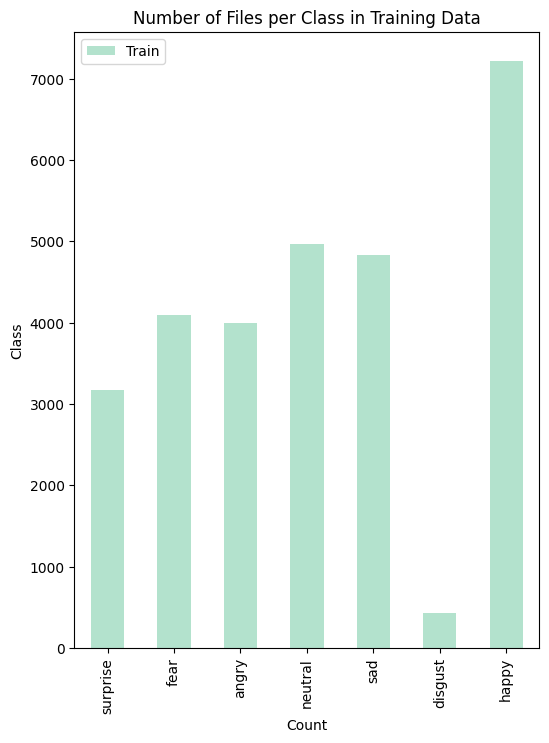

In [ ]:
# Transpose the DataFrame and plot a Train bar chart
train_count.transpose().plot(kind='bar' ,figsize=(6, 8), colormap='Pastel2')

# Set plot labels and title
plt.xlabel('Count')
plt.ylabel('Class')
plt.title('Number of Files per Class in Training Data')

# Show the plot
plt.show()

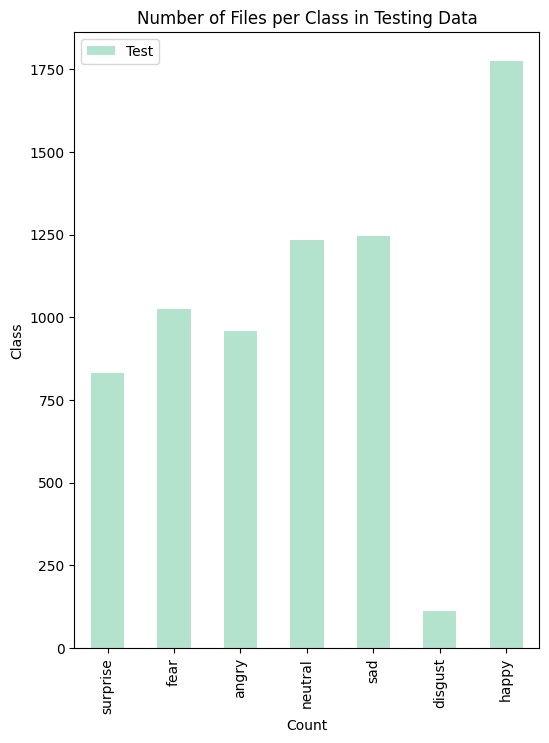

In [ ]:
# Transpose the DataFrame and plot a Test bar chart
test_count.transpose().plot(kind='bar' ,figsize=(6, 8), colormap='Pastel2')

# Set plot labels and title
plt.xlabel('Count')
plt.ylabel('Class')
plt.title('Number of Files per Class in Testing Data')

# Show the plot
plt.show()

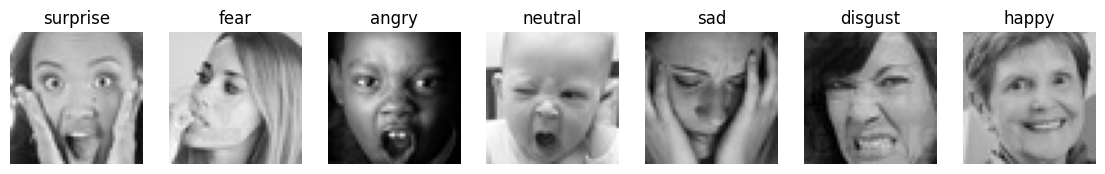

In [ ]:
# Display images from each expression directory if at least six images exist
plt.figure(figsize=(14, 22))
i = 1

for expression in os.listdir(train_dir):
    files_in_expression = os.listdir(os.path.join(train_dir, expression))

    # Check if there are at least six files in the directory
    if len(files_in_expression) >= 6:
        img = load_img(os.path.join(train_dir, expression, files_in_expression[5]))
        plt.subplot(1, 7, i)
        plt.imshow(img)
        plt.title(expression)
        plt.axis('off')
        i += 1

plt.show()

# **Data Preprocessing**

In [ ]:
img_shape = 224  # Update image size to match ResNet50V2 input size
batch_size = 64

# Image data preprocessing for training dataset
train_preprocessor = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
)

# Image data preprocessing for testing dataset
test_preprocessor = ImageDataGenerator(rescale=1.0/255.0)

# Flowing images from directories with updated target size
train_data = train_preprocessor.flow_from_directory(
    train_dir,
    class_mode="categorical",
    target_size=(img_shape, img_shape),  # Updated target size
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)

test_data = test_preprocessor.flow_from_directory(
    test_dir,
    class_mode="categorical",
    target_size=(img_shape, img_shape),  # Updated target size
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# Path to the downloaded ResNet50V2 weights file
weights_path = "/kaggle/input/restnetweights/resnet50v2_weights_tf_dim_ordering_tf_kernels_notop (1).h5"

# Load the ResNet50V2 model with the downloaded weights
ResNet50V2_model = ResNet50V2(weights=None, include_top=False, input_shape=(224, 224, 3))
ResNet50V2_model.load_weights(weights_path)

# Compile the model if needed
ResNet50V2_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Freezing all layers except the last 50
for layer in ResNet50V2_model.layers[:-50]:
    layer.trainable = False

def Create_ResNet50V2_Model():
    model = Sequential([
        ResNet50V2_model,
        Flatten(),
        Dropout(0.25),
        BatchNormalization(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(7, activation='softmax')
    ])
    return model

In [ ]:
ResNet50V2_Model = Create_ResNet50V2_Model()

ResNet50V2_Model.summary()

ResNet50V2_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dropout (Dropout)            (None, 100352)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100352)            401408    
_________________________________________________________________
dense (Dense)                (None, 64)                6422592   
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [ ]:
# Create Callback Checkpoint
checkpoint_path = "ResNet50V2Model.h5"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 4, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [ ]:
ResNet50V2_history = ResNet50V2_Model.fit(train_data ,validation_data = test_data , epochs=11, batch_size=batch_size,
                                         callbacks = callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
ResNet50V2_Model.save('ResNet50V2Model.h5')

Epoch 1/11
448/448 [==============================] - 3464s 8s/step - loss: 1.5393 - accuracy: 0.4633 - val_loss: 1.2638 - val_accuracy: 0.5469
Epoch 2/11
448/448 [==============================] - 3478s 8s/step - loss: 1.1927 - accuracy: 0.5664 - val_loss: 1.0927 - val_accuracy: 0.5968
Epoch 3/11
448/448 [==============================] - 3497s 8s/step - loss: 1.0998 - accuracy: 0.6003 - val_loss: 1.2071 - val_accuracy: 0.6180
Epoch 4/11
448/448 [==============================] - 3490s 8s/step - loss: 1.0528 - accuracy: 0.6168 - val_loss: 1.1269 - val_accuracy: 0.5958

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 5/11
448/448 [==============================] - 3468s 8s/step - loss: 0.9464 - accuracy: 0.6571 - val_loss: 0.9304 - val_accuracy: 0.6588
Epoch 6/11
448/448 [==============================] - 3473s 8s/step - loss: 0.9084 - accuracy: 0.6721 - val_loss: 0.9253 - val_accuracy: 0.6610
Epoch 7/11
448/448 [==============================] - 

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
from tensorflow.keras.models import load_model

# Replace 'ResNet50V2_Model_path' with the path where your ResNet50V2 model is saved
ResNet50V2_Model_path = 'ResNet50V2Model.h5'

# Load the ResNet50V2 model
ResNet50V2_Model = load_model(ResNet50V2_Model_path)

# Evaluate the loaded ResNet50V2 model on test data
ResNet50V2_Score = ResNet50V2_Model.evaluate(test_data)

# Print the evaluation metrics with formatting
print("    Test Loss: {:.5f}".format(ResNet50V2_Score[0]))
print("Test Accuracy: {:.2f}%".format(ResNet50V2_Score[1] * 100))

113/113 [==============================] - 408s 4s/step - loss: 1.0974 - accuracy: 0.6737
    Test Loss: 1.09735
Test Accuracy: 67.37%


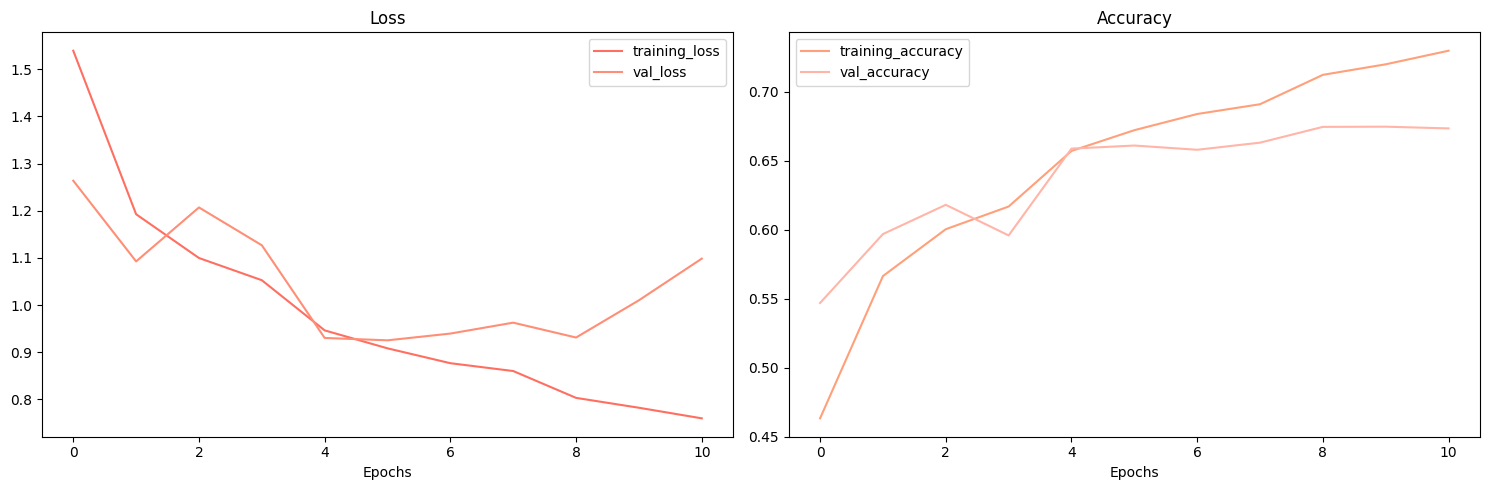

In [ ]:
import matplotlib.pyplot as plt

# Define pastel coral color palette
colors = ['#FF6F61', '#FF8E76', '#FFA07A', '#FFB5A7']

# Assuming 'ResNet50V2_history' contains your ResNet50V2 model's training history
ResNet50V2_loss = ResNet50V2_history.history["loss"]
ResNet50V2_val_loss = ResNet50V2_history.history["val_loss"]

ResNet50V2_accuracy = ResNet50V2_history.history["accuracy"]
ResNet50V2_val_accuracy = ResNet50V2_history.history["val_accuracy"]

epochs = range(len(ResNet50V2_history.history["loss"]))

plt.figure(figsize=(15, 5))

# Plot loss with pastel coral colors
plt.subplot(1, 2, 1)
plt.plot(epochs, ResNet50V2_loss, label="training_loss", color=colors[0])
plt.plot(epochs, ResNet50V2_val_loss, label="val_loss", color=colors[1])
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot accuracy with pastel coral colors
plt.subplot(1, 2, 2)
plt.plot(epochs, ResNet50V2_accuracy, label="training_accuracy", color=colors[2])
plt.plot(epochs, ResNet50V2_val_accuracy, label="val_accuracy", color=colors[3])
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
ResNet50V2_Model = load_model('ResNet50V2Model.h5')
# Predict classes for test data using ResNet50V2_Model
ResNet50V2_Predictions = ResNet50V2_Model.predict(test_data)
ResNet50V2_Predictions = np.argmax(ResNet50V2_Predictions, axis=1)

In [ ]:
# Get true labels from test data
true_labels = test_data.classes

# Get class labels from training data
class_indices = test_data.class_indices
class_labels = list(class_indices.keys())

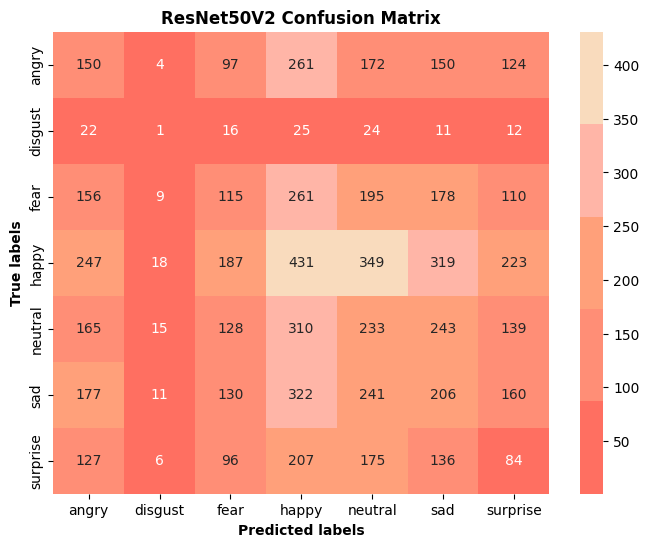

In [ ]:

# Compute confusion matrix
cm = confusion_matrix(true_labels, ResNet50V2_Predictions)

# Set a pastel color palette
colors = ['#FF6F61', '#FF8E76', '#FFA07A', '#FFB5A7', '#F9DBBD']

# Create a heatmap with the specified color palette and class labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap=colors, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels', fontsize=10, fontweight='bold')
plt.ylabel('True labels', fontsize=10, fontweight='bold')
plt.title('ResNet50V2 Confusion Matrix', fontsize=12, fontweight='bold')
plt.show()


In [ ]:
Emotion_Classes = ['Angry',
                  'Disgust',
                  'Fear',
                  'Happy',
                  'Neutral',
                  'Sad',
                  'Surprise']

# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_data = test_preprocessor.flow_from_directory(
    test_dir,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 7178 images belonging to 7 classes.


# **Visualizing Predictions**

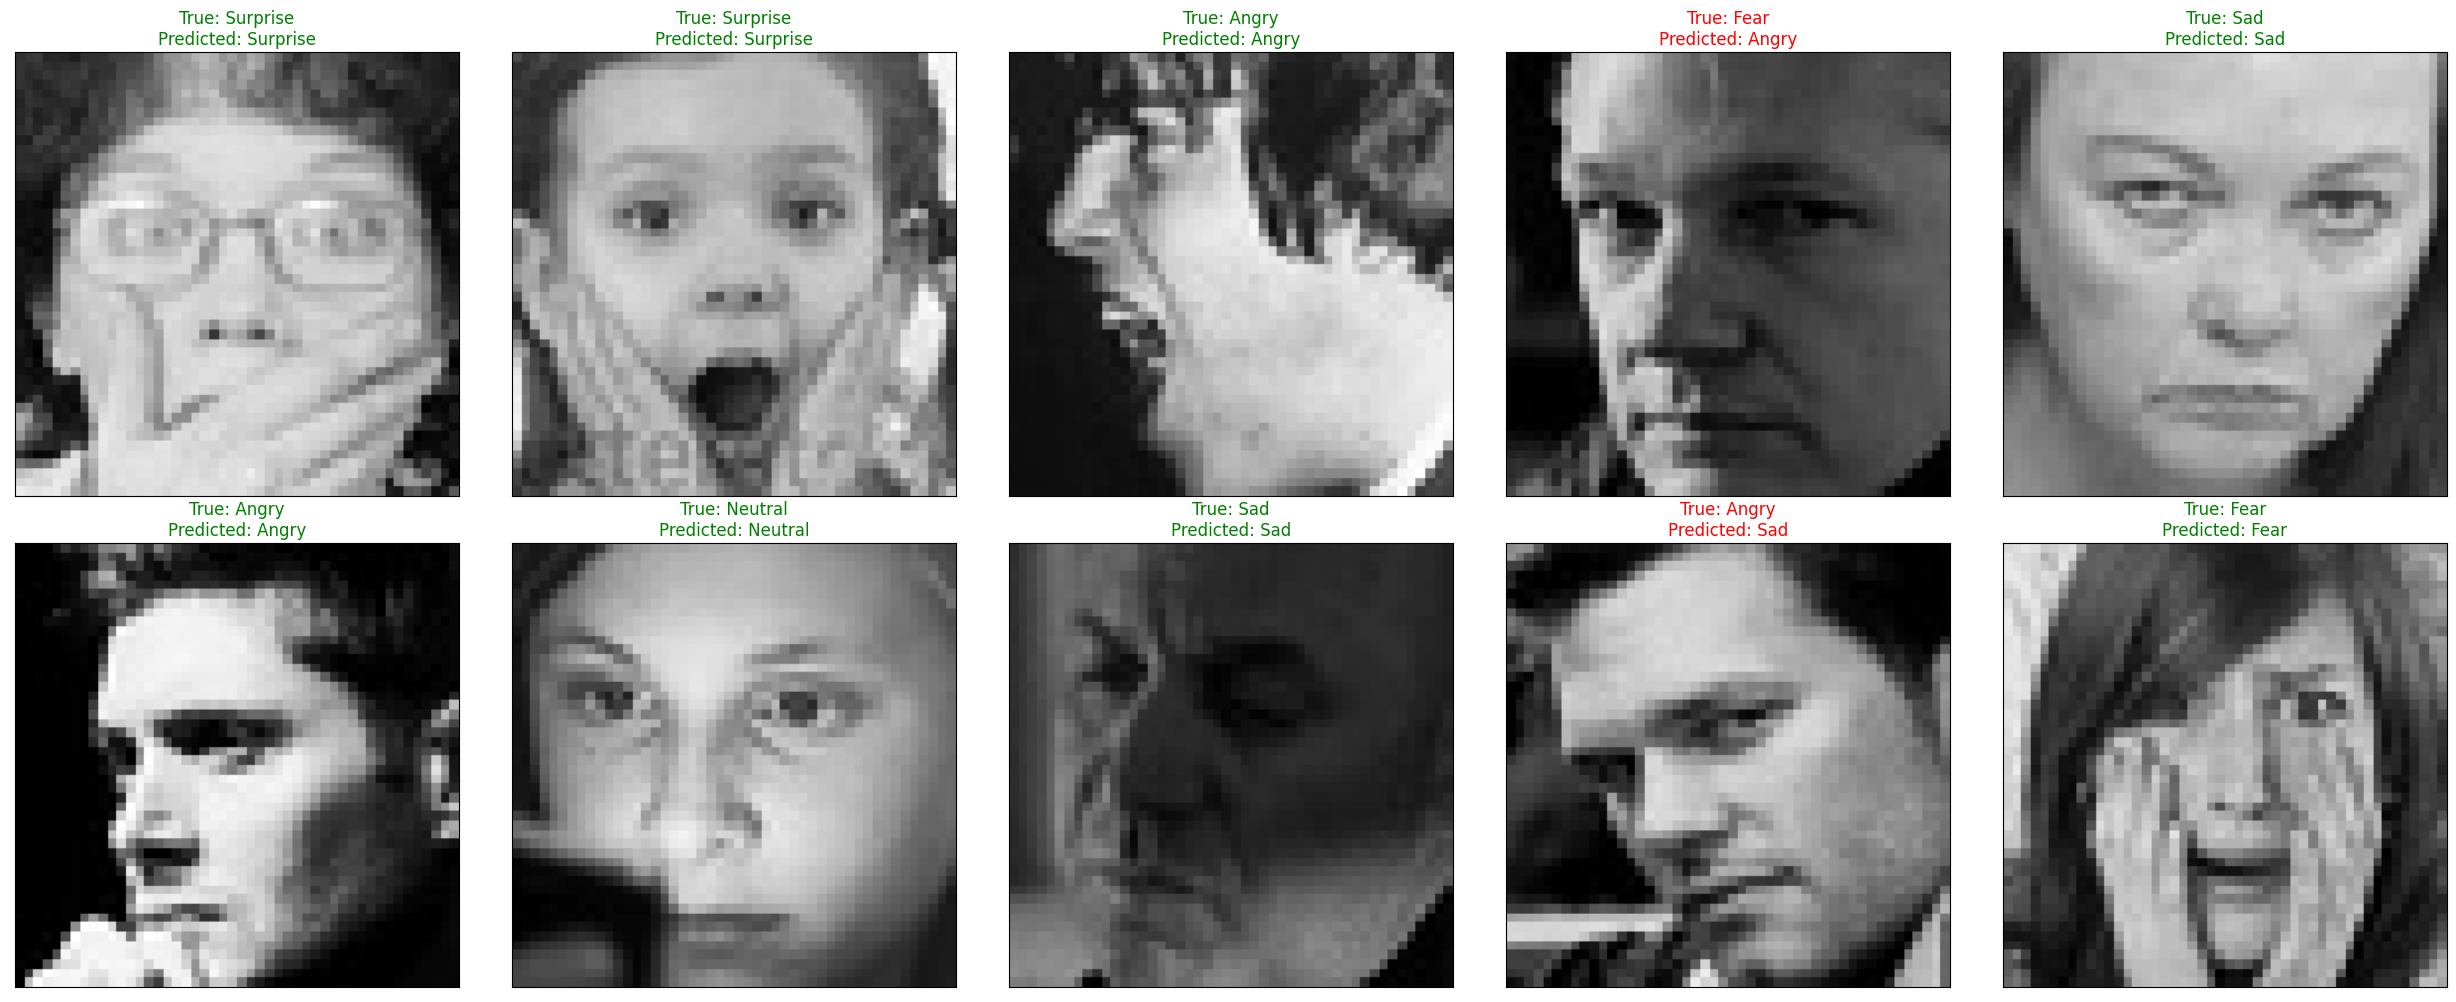

In [ ]:
from tensorflow.image import resize as tf_resize

# Display 10 random pictures from the dataset with their labels and predictions
Random_batch = np.random.randint(0, len(test_data) - 1)
Random_Img_Index = np.random.randint(0, batch_size - 1, 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    Random_Img = test_data[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_data[Random_batch][1][Random_Img_Index[i]])

    # Resize the images to match the model's input size using bilinear interpolation
    resized_images = tf_resize(Random_Img, (224, 224), method='bilinear')

    # Perform the prediction on the resized images
    Model_Prediction = np.argmax(ResNet50V2_Model.predict(tf.expand_dims(resized_images, axis=0), verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
        color = "green"
    else:
        color = "red"

    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()
